In [506]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing

warnings.filterwarnings("ignore")

In [507]:
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Carrega os arquivos de 2023 e 2022
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)


# Concatena os DataFrames
df = pd.concat([df_2024, df_2023, df_2022])
df = df.dropna()

# Filtra as linhas referentes à nubank
SBSP3_df = df[df['Codigo'].str.endswith('SBSP3')]
df = SBSP3_df

print(df)


             Data   Codigo  Preco_Abertura  Preco_Fechamento
164      20240102  02SBSP3          7535.0            7298.0
2002     20240103  02SBSP3          7355.0            7322.0
3781     20240104  02SBSP3          7350.0            7202.0
5255     20240105  02SBSP3          7240.0            7202.0
7061     20240108  02SBSP3          7205.0            7186.0
...           ...      ...             ...               ...
1228391  20221207  02SBSP3          5624.0            5624.0
1230368  20221027  02SBSP3          5732.0            5697.0
1231126  20221103  02SBSP3          5911.0            5884.0
1232459  20221201  02SBSP3          5989.0            5940.0
1233743  20221129  02SBSP3          6006.0            5895.0

[559 rows x 4 columns]


In [508]:
df['Data'] = pd.to_datetime(df['Data'], format='%Y%m%d')

# Extraindo ano, mês e dia
df['Ano'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df['Dia'] = df['Data'].dt.day

print(df)

              Data   Codigo  Preco_Abertura  Preco_Fechamento   Ano  Mes  Dia
164     2024-01-02  02SBSP3          7535.0            7298.0  2024    1    2
2002    2024-01-03  02SBSP3          7355.0            7322.0  2024    1    3
3781    2024-01-04  02SBSP3          7350.0            7202.0  2024    1    4
5255    2024-01-05  02SBSP3          7240.0            7202.0  2024    1    5
7061    2024-01-08  02SBSP3          7205.0            7186.0  2024    1    8
...            ...      ...             ...               ...   ...  ...  ...
1228391 2022-12-07  02SBSP3          5624.0            5624.0  2022   12    7
1230368 2022-10-27  02SBSP3          5732.0            5697.0  2022   10   27
1231126 2022-11-03  02SBSP3          5911.0            5884.0  2022   11    3
1232459 2022-12-01  02SBSP3          5989.0            5940.0  2022   12    1
1233743 2022-11-29  02SBSP3          6006.0            5895.0  2022   11   29

[559 rows x 7 columns]


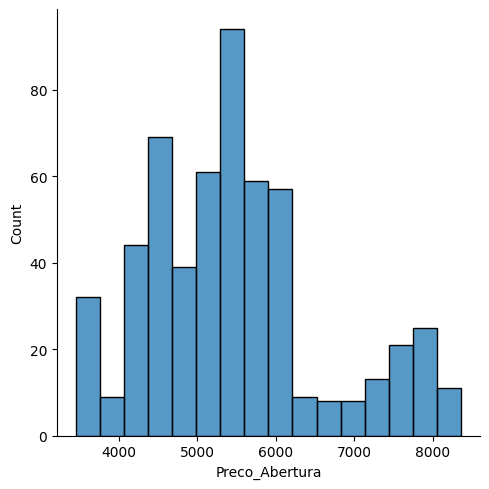

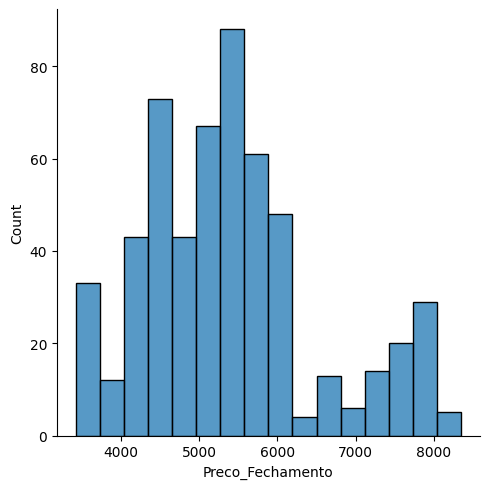

In [509]:
sns.displot(df['Preco_Abertura'])
sns.displot(df['Preco_Fechamento'])

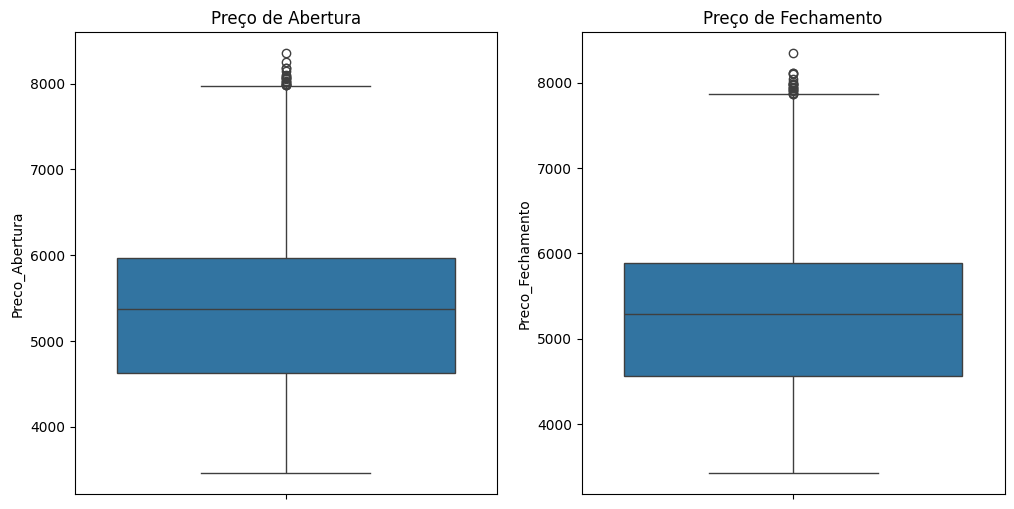

In [510]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot para o preço de abertura
sns.boxplot(ax=axes[0], data=df['Preco_Abertura'])
axes[0].set_title('Preço de Abertura')

# Boxplot para o preço de fechamento
sns.boxplot(ax=axes[1], data=df['Preco_Fechamento'])
axes[1].set_title('Preço de Fechamento')

plt.show()

In [511]:
upper_limit = df['Preco_Abertura'].mean() + 3 * df['Preco_Abertura'].std()
lower_limit = df['Preco_Abertura'].mean() - 3 * df['Preco_Abertura'].std()
print('Abertura upper limit: ', upper_limit)
print('Abertura lower limit: ', lower_limit)

upper_limit = df['Preco_Fechamento'].mean() + 3 * df['Preco_Fechamento'].std()
lower_limit = df['Preco_Fechamento'].mean() - 3 * df['Preco_Fechamento'].std()
print('Fechamento upper limit: ', upper_limit)
print('Fechamento lower limit: ', lower_limit)

Abertura upper limit:  8872.839305668738
Abertura lower limit:  2058.9603365495104
Fechamento upper limit:  8777.291884540447
Fechamento lower limit:  2001.430834600877


In [512]:
df.loc[(df['Preco_Fechamento'] > upper_limit) | (df['Preco_Fechamento'] < lower_limit)]

,Data,Codigo,Preco_Abertura,Preco_Fechamento,Ano,Mes,Dia


In [513]:
df.loc[(df['Preco_Abertura'] > upper_limit) | (df['Preco_Fechamento'] < lower_limit)]

,Data,Codigo,Preco_Abertura,Preco_Fechamento,Ano,Mes,Dia


In [514]:
#Definindo a coluna data como index da tabela
df = df.sort_values(by='Data')
df.set_index(df['Data'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 559 entries, 2022-01-03 to 2024-03-28
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Data              559 non-null    datetime64[ns]
 1   Codigo            559 non-null    object        
 2   Preco_Abertura    559 non-null    float64       
 3   Preco_Fechamento  559 non-null    float64       
 4   Ano               559 non-null    int32         
 5   Mes               559 non-null    int32         
 6   Dia               559 non-null    int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(1)
memory usage: 28.4+ KB


<Axes: xlabel='Data'>

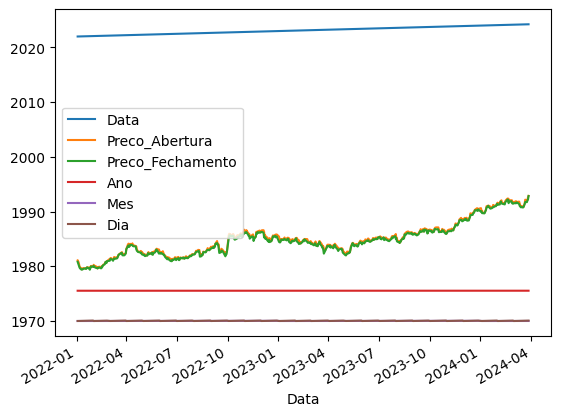

In [515]:
df.info()
df.plot()

In [516]:
from statsmodels.tsa.stattools import adfuller

adf_test_abertura = adfuller(df['Preco_Abertura'])
# Output the results
print('ADF Statistic Abertura: %f' % adf_test_abertura[0])
print('p-value: %f' % adf_test_abertura[1])

adf_test_fechamento = adfuller(df['Preco_Fechamento'])
# Output the results
print('\nADF Statistic Fechamento: %f' % adf_test_fechamento[0])
print('p-value: %f' % adf_test_fechamento[1])

ADF Statistic Abertura: 0.005809
p-value: 0.959010

ADF Statistic Fechamento: -0.097791
p-value: 0.949658


In [517]:
# df['Preco_Abertura'] = df['Preco_Abertura'].diff()
# df['Preco_Fechamento'] = df['Preco_Fechamento'].diff()

# # Removendo os valores NaN resultantes da diferenciação
# df.dropna(inplace=True)

# # Executando o teste ADF na série diferenciada
# adf_test_diff_abertura = adfuller(df['Preco_Abertura'])
# adf_test_diff_fechamento = adfuller(df['Preco_Fechamento'])

# # Output the results
# print('ADF Statistic Abertura (Differenced Series): %f' % adf_test_diff_abertura[0])
# print('p-value (Differenced Series): %f' % adf_test_diff_abertura[1])
# print('\nADF Statistic Fechamento (Differenced Series): %f' % adf_test_diff_fechamento[0])
# print('p-value (Differenced Series): %f' % adf_test_diff_fechamento[1])

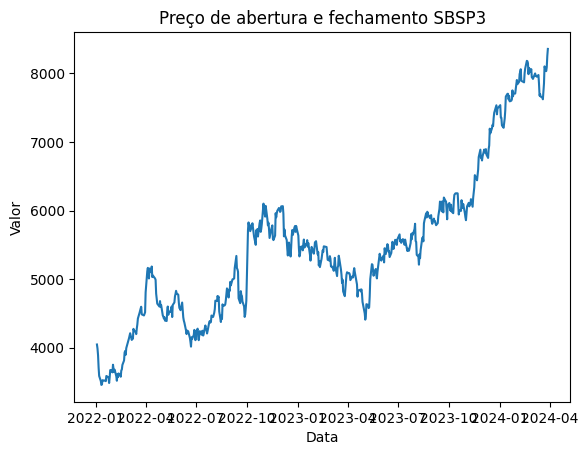

In [518]:
# Plot the time series
plt.plot(df['Preco_Abertura'])
plt.title('Preço de abertura e fechamento SBSP3')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

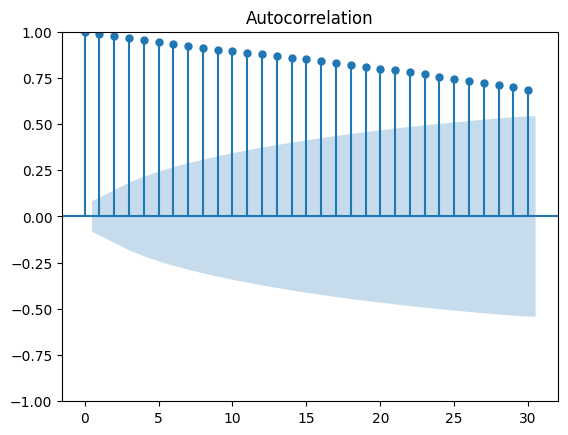

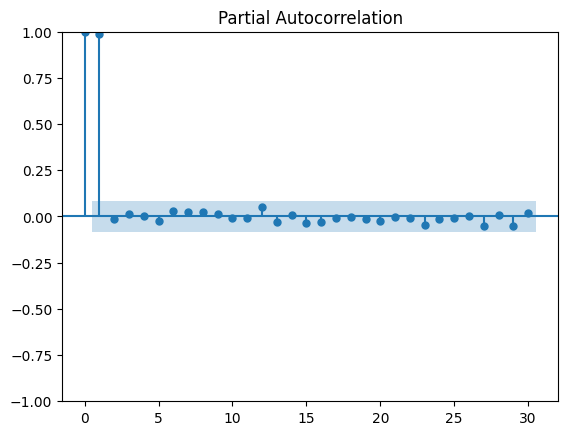

In [523]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Preco_Abertura'], lags=30)
plot_pacf(df['Preco_Abertura'], lags=30)
plt.show()

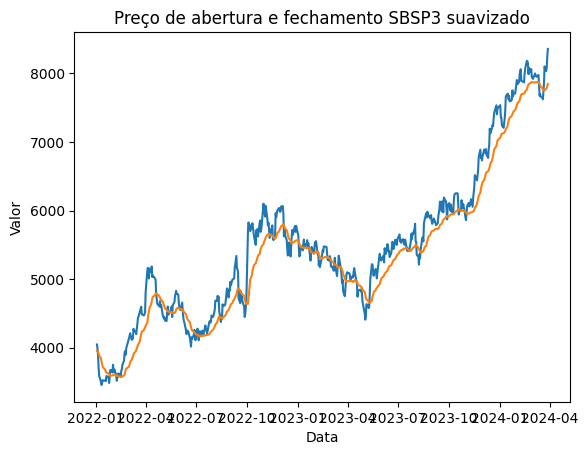

In [520]:
alpha = 0.1
model_exp = SimpleExpSmoothing(df['Preco_Fechamento']).fit(smoothing_level=alpha)
df['Preco_Abertura_Suavizado'] = model_exp.fittedvalues

df.dropna(inplace=True)

plt.plot(df['Preco_Abertura'])
plt.plot(df['Preco_Abertura_Suavizado'])
plt.title('Preço de abertura e fechamento SBSP3 suavizado')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [521]:
model = ARIMA(df['Preco_Abertura'], order=(1, 0, 1))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=30)

RMSE Preço de Abertura: 1325.6363082768926
RMSE Preço de Fechamento: 1599.1166702081543


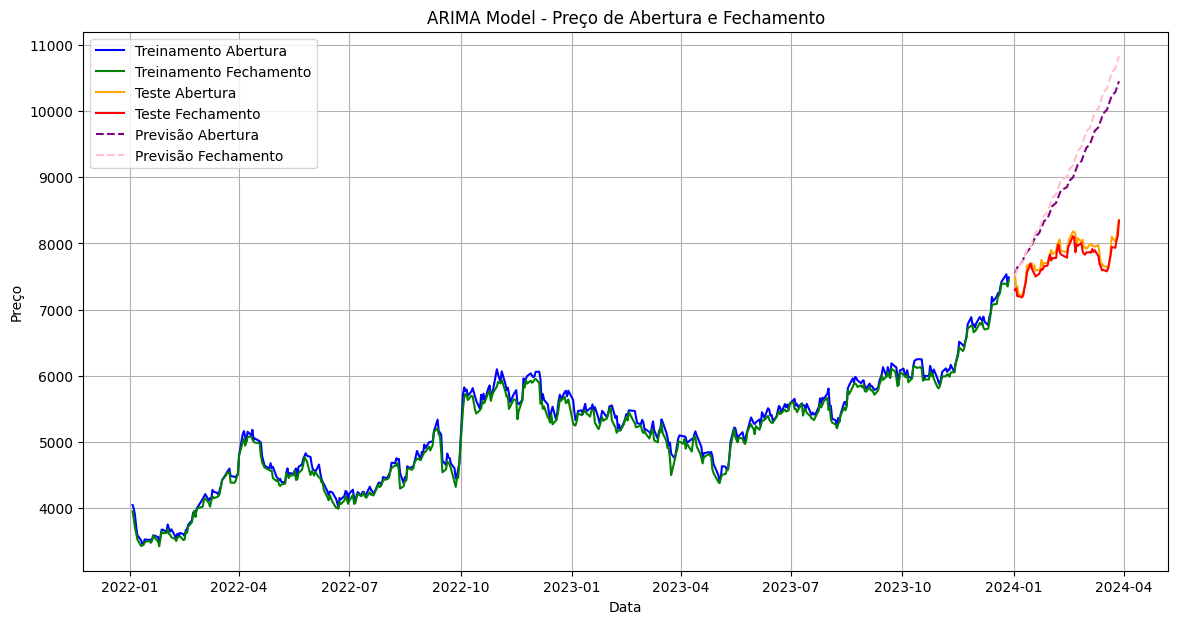

In [522]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Supondo que df é o seu DataFrame com as colunas 'Preco_Abertura' e 'Preco_Fechamento'

# Convertendo o índice para datetime se necessário
df.index = pd.to_datetime(df.index)

# Filtrando os dados de treinamento (de 2022 a 2023) e teste (ano de 2024)
train_data = df[(df.index.year >= 2022) & (df.index.year <= 2023)]
test_data = df[df.index.year == 2024]

# Separando os dados de treinamento para Preço de Abertura e Preço de Fechamento
train_abertura = train_data['Preco_Abertura']
train_fechamento = train_data['Preco_Fechamento']

# Ajustando o modelo ARIMA para Preço de Abertura e Preço de Fechamento
order = (10, 3, 2)  # Parâmetros do modelo ARIMA (p, d, q)
modelo_abertura = ARIMA(train_abertura, order=order)
modelo_fechamento = ARIMA(train_fechamento, order=order)

# Treinando o modelo ARIMA para Preço de Abertura e Preço de Fechamento
modelo_abertura_fit = modelo_abertura.fit()
modelo_fechamento_fit = modelo_fechamento.fit()

# Fazendo previsões para o ano de 2024
predicoes_abertura = modelo_abertura_fit.forecast(steps=len(test_data))
predicoes_fechamento = modelo_fechamento_fit.forecast(steps=len(test_data))

# Calculando o erro
mse_abertura = mean_squared_error(test_data['Preco_Abertura'], predicoes_abertura)
rmse_abertura = mse_abertura ** 0.5

mse_fechamento = mean_squared_error(test_data['Preco_Fechamento'], predicoes_fechamento)
rmse_fechamento = mse_fechamento ** 0.5

print('RMSE Preço de Abertura:', rmse_abertura)
print('RMSE Preço de Fechamento:', rmse_fechamento)

# Plot dos resultados
plt.figure(figsize=(14, 7))
plt.plot(train_abertura.index, train_abertura, label='Treinamento Abertura', color='blue')
plt.plot(train_fechamento.index, train_fechamento, label='Treinamento Fechamento', color='green')
plt.plot(test_data.index, test_data['Preco_Abertura'], label='Teste Abertura', color='orange')
plt.plot(test_data.index, test_data['Preco_Fechamento'], label='Teste Fechamento', color='red')
plt.plot(test_data.index, predicoes_abertura, label='Previsão Abertura', color='purple', linestyle='--')
plt.plot(test_data.index, predicoes_fechamento, label='Previsão Fechamento', color='pink', linestyle='--')
plt.title('ARIMA Model - Preço de Abertura e Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()
